# Initializing imports, helper functions and initial data extraction

In [14]:
import numpy as np
import scipy.io as sio # For loadmat, which imports data from Matlab files and stores them in memory as scipy tensors
import matplotlib.pyplot as plt # For graphing and plotting

# For filtering
from scipy import signal
from scipy.signal import butter, sosfiltfilt, find_peaks

# Only if on GoogleColab, do the following 2 lines (otherwise comment out):
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/School_and_Work/UW/560_Project_2/' # CHANGE THIS TO YOUR FOLDER
import os
os.chdir(path) # Change directory to where the data and function are stored
from filter500to5k_AvailabletoStudents import filter500to5k

# Update data_path to point to your downloaded data
data_path = "ECoGData_AvailabletoStudents.mat"
data = sio.loadmat(data_path)

# Create some references to the data so the user doesn't need to copy/paste this indexing elsewhere.
# This first one appears as data.Signal in the Matlab structure. e.g. data_ecog[0] is data.Signal{1, 1}
# data["data"]["Signal"][0][0][0][0] is constant illumination 1s,
# data["data"]["Signal"][0][0][0][1] is 3Hz sine wave 1s,
# data["data"]["Signal"][0][0][0][2] is 10Hz sine wave 1s.
# All for 50
data_ecog = data["data"]["Signal"][0][0][0]
stim_times = data["data"]["StimTimes"][0][0][0]
Fs = data["data"]["SamplingFreq"][0][0][0][0]

print("Signal: " + str(data_ecog.shape))  # Three stim conditions
print("Stim Times: " + str(stim_times.shape))  # in seconds!
print("SFreq: " + str(Fs))  # 24414 Hz


# For bandpass filtering consider these functions, but check your work!
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Signal: (3,)
Stim Times: (3,)
SFreq: 24414.0625


In [15]:
# Data Exploration

# print(data["data"]["Signal"][0][0][0])
# print(data["data"]["StimTimes"][0][0][0])
# print(data["data"]["SamplingFreq"][0][0][0][0])
# print(data_ecog[0])
# print(stim_times[0])
# print(Fs)

# print(data["data"].dtype.names)
# ('SamplingFreq', 'Signal', 'StimTimes')

# a.)

In [16]:
# Place data into one list each (instead of each datapoint in an array with only itself)
ecog_data = []
for i in range(len(data_ecog)):
  ecog_data.append(data_ecog[i].flatten())
# print(ecog_data)

In [17]:
# Filtering signal between 500 and 5000 Hz
sos = filter500to5k(Fs) # Function imported
# print(sos)
filter_data = []
for i in range(len(ecog_data)):
  filter_data.append(sosfiltfilt(sos, ecog_data[i]))
# print(filter_data)

In [18]:
# Calculate threshold
thresh = []
for i in range(len(filter_data)):
  thresh.append(np.median(np.abs(filter_data[i] / 0.6745)) * 3)
# print(thresh)

In [19]:
# Rectifying signal for threshold detection based on threshold
ind_peaks = [[] for i in range(len(thresh))] # Indices of peaks
for i in range(len(thresh)):
  peaks, _ = find_peaks(filter_data[i], height = thresh[i])
  ind_peaks[i] = peaks
# print(ind_peaks[0])

In [20]:
# Convert peaks (indexes) to time using the sampling frequency
peaks_t = [[] for i in range(len(ind_peaks))] # Timestamp of peaks
for i in range(len(ind_peaks)):
  peaks_t[i] = ind_peaks[i] / Fs
# print(peaks_t)

# b.)

In [21]:
# Formatting data to get spike times between 0.5s before and after stimulation onset
spike_times = [[] for i in range(len(stim_times))]
for pattern in range(len(peaks_t)): # Patterns
  spike_t = [[] for i in range(len(stim_times[pattern]))]
  for trial in range(len(stim_times[pattern])): # Trials
    # Get list of spike timestamps before and after stimulation onset
    timestamp = peaks_t[pattern][(peaks_t[pattern] > stim_times[pattern][trial][0] - 0.5) & (peaks_t[pattern] < stim_times[pattern][trial][0] + 1.5)]
    # Format list with each value being a list of just itself
    timestamp_list = [[] for i in range(len(timestamp))]
    for i in range(len(timestamp)):
      timestamp_list[i].append(timestamp[i])
    # print(timestamp_list)
    timestamp_array = np.array(timestamp_list)
    spike_t[trial].append(timestamp_array)
  # print(spike_t)
  spike_times[pattern].append(spike_t)
# print(spike_times[0])

<ipython-input-38-346f7ef6b558>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(spike_t, np.ones(len(spike_t)) * (ti + 1), 'k|', color = 'green')


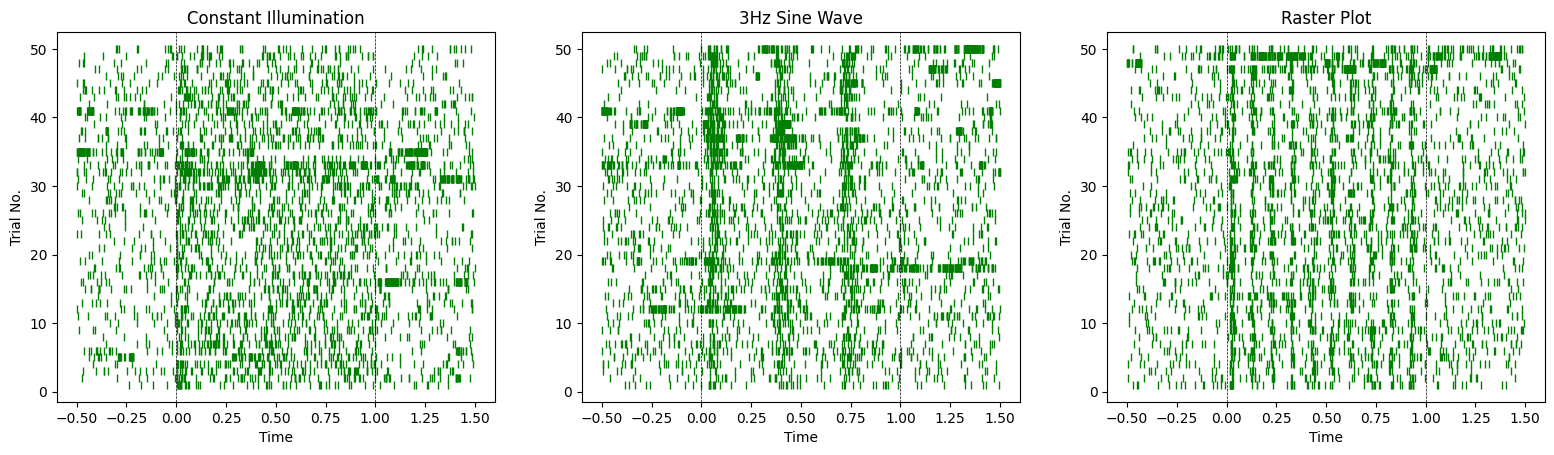

In [38]:
# Plot data for 50 trials for each of the three patterns as a Raster Plot
title = ['Constant Illumination', '3Hz Sine Wave', '10Hz Sine Wave']
fig, axs = plt.subplots(1, 3)
for i in range(len(stim_times)): # Experiments
  for ti in range(stim_times[i].size): # Trials
    spike_t = spike_times[i][0][ti][0] - stim_times[i][ti]
    axs[i].plot(spike_t, np.ones(len(spike_t)) * (ti + 1), 'k|', color = 'green')
  # print(spike_t)
  axs[i].set_xlabel('Time')
  axs[i].set_ylabel('Trial No.')
  axs[i].set_title(title[i])
  axs[i].axvline(x = 0, color = 'black', linewidth = 0.5, linestyle='--')
  axs[i].axvline(x = 1, color = 'black', linewidth = 0.5, linestyle='--')
fig.set_size_inches(19.2, 4.8)
plt.show()

# c.)

In [ ]:
# Calculating Firing Rate
bin_size = 0.02 # In seconds (20 ms)
bins = np.arange(-0.5, 1.5 + bin_size, bin_size)
firing_rate_per_pattern = [[] for i in range(len(spike_times))]

for pattern in range(len(spike_times)): # Patterns
  firing_rate = [[] for i in range(len(spike_times[pattern][0]))]
  for trial in range(len(spike_times[pattern][0])): # Trials
    spike_t = spike_times[pattern][0][trial][0].flatten() - stim_times[pattern][trial]
    spikes_hist, _ = np.histogram(spike_t, bins = bins)
    firing_rate[trial].append((spikes_hist / len(spike_times[pattern][0])) / bin_size)
  # print(firing_rate)
  firing_rate_per_pattern[pattern].append(firing_rate)
# print(firing_rate_per_pattern)
# print(firing_rate)

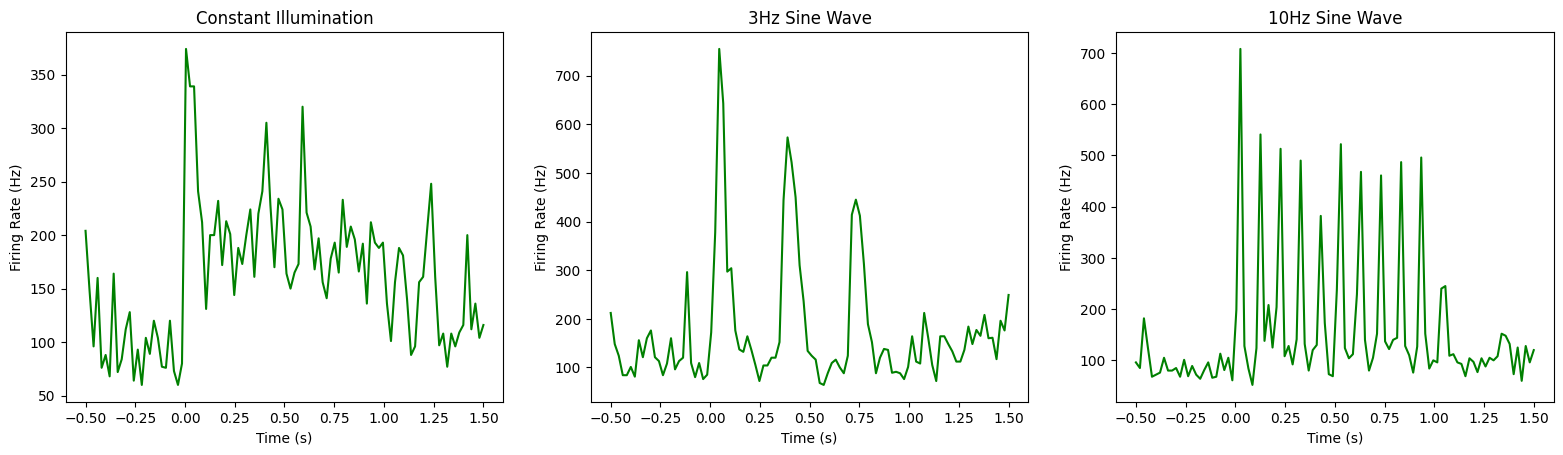

In [41]:
# Plot data for 50 trials for each of the three patterns for firing rate
title = ['Constant Illumination', '3Hz Sine Wave', '10Hz Sine Wave']
fig, axs = plt.subplots(1, 3)
for pattern in range(len(firing_rate_per_pattern)): # Patterns
  avg_firing_rate = firing_rate_per_pattern[pattern][0][0][0]
  for trial in range(len(spike_times[pattern][0])): # Trials
    if (trial == 0):
      continue
    avg_firing_rate += firing_rate_per_pattern[pattern][0][trial][0]
  # print(avg_firing_rate)
  axs[pattern].plot(np.linspace(-0.5, 1.5, len(avg_firing_rate)), avg_firing_rate, color = 'green')
  axs[pattern].set_xlabel('Time (s)')
  axs[pattern].set_ylabel('Firing Rate (Hz)')
  axs[pattern].set_title(title[pattern])
fig.set_size_inches(19.2, 4.8)
plt.show()